# Titanic - Machine Learning from Disaster
#### Author: James Coffey
#### Date: 5/27/2025
#### Challenge URL: [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic)

# Business Understanding

> **Goal:** Align on the problem, success metrics, and constraints before touching any data.

## Problem Definition

- Predict whether a Titanic passenger survived the shipwreck using available passenger data.
- **Target variable:** `Survived` (0 = No, 1 = Yes).

## Context & Scope

- Historical dataset from the RMS Titanic’s maiden voyage (April 1912).
- **Train set:** 891 passengers with known outcomes.
- **Test set:** 418 passengers; outcomes withheld for Kaggle leaderboard scoring.
- Real-world context vs. Kaggle competition framing: leveraging historical data for a classification task.

## Stakeholders

- **Competition stakeholders:** Kaggle community, competition host, and participating data scientists.
- **Real-world stakeholders (for context):** maritime historians, educators, safety analysts.

## Success Metrics

- **Primary:** Maximize classification accuracy on the test set (per Kaggle scoring).
- **Secondary:** Track ROC-AUC and log-loss on cross-validation to assess confidence and probabilistic calibration.

## Constraints

- **Data constraints:** Static CSVs with 12 original columns; no external data allowed.
- **Feature constraints:** 11 features plus ID; must engineer additional signals if needed.
- **Compute constraints:** Code must run within Kaggle Notebook CPU/GPU and memory limits.
- **Time constraints:** Hyperparameter searches and training should complete within notebook runtime.
- **Legal/privacy:** All data is public and anonymized; no additional considerations.

## Assumptions & Risks

- **Assumptions:** Train and test distributions are stable; missingness is random or can be imputed safely.
- **Risks:** Overfitting to public leaderboard; leakage from inadvertently using test data; biases due to missing values.

# Data Acquisition

> **Goal:** Identify, access, and gather all relevant raw data for the Titanic competition.

## Sources

CSV files provided by Kaggle:

- `train.csv` (891 rows, survival labels)
- `test.csv` (418 rows, labels withheld)
- `gender_submission.csv` (example submission format)

Download with:
```bash
kaggle competitions download -c titanic
```  

## Coverage & Granularity

- **Train set:** 891 passengers, 12 columns (PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked)
- **Test set:** 418 passengers, same 11 features (excluding `Survived`).
- **Timeframe:** April 1912, RMS Titanic’s maiden voyage.

## Authentication & Access

- No special credentials required: Kaggle API handles authentication via configured API token.
- Ensure `~/.kaggle/kaggle.json` is present with read permissions.

## Metadata Handling

```python
# Inspect data description
with open('data_description.txt', 'r') as f:
    description = f.read()
print(description)
```

Convert key mappings (e.g., Embarked: C=Cherbourg, Q=Queenstown, S=Southampton) into a reference table:

```python
meta = {
    'Survived': '0 = No, 1 = Yes',
    'Pclass': '1 = 1st, 2 = 2nd, 3 = 3rd',
    'Sex': 'male/female',
    'Age': 'in years',
    'SibSp': 'siblings/spouses aboard',
    'Parch': 'parents/children aboard',
    'Fare': 'ticket fare',
    'Cabin': 'cabin number',
    'Embarked': 'C = Cherbourg, Q = Queenstown, S = Southampton'
}
meta_df = pd.DataFrame.from_dict(meta, orient='index', columns=['Description'])
meta_df
```  

# Imports & Settings

> **Goal:** Set up the environment, imports, and configuration so the notebook runs cleanly and reproducibly.

In [1]:
# %%capture

# --- Standard library ---
import math
import os
import random
import sys
import warnings

# --- Third-party ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import xgboost as xgb
import ydf

# --- Optuna utilities ---
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler

# --- Path setup (optional) ---
# nb_dir = os.path.dirname(os.path.abspath("__file__"))        # this notebook dir
# top_dir = os.path.abspath(os.path.join(nb_dir, '..'))         # project root
# tmp_src = os.path.join(top_dir, 'src')
# if tmp_src not in sys.path:
#     sys.path.insert(0, tmp_src)

# --- Notebook display ---
%matplotlib inline

# --- Environment & warnings ---
warnings.filterwarnings("ignore", category=FutureWarning)
# Global seeds
np.random.seed(42)

# --- Library-specific logging ---
optuna.logging.set_verbosity(optuna.logging.ERROR)
save_verbose = ydf.verbose(0)

# Apply the default theme
sns.set_theme()

## Verification & Reproducibility

Run a quick import test and print version numbers for critical libraries:

In [2]:
import numpy as _np, pandas as _pd, xgboost as _xgb, optuna as _opt, ydf as _ydf
print(
    "Versions:\n",
    f"numpy:      {_np.__version__}\n",
    f"pandas:     {_pd.__version__}\n",
    f"xgboost:    {_xgb.__version__}\n",
    f"optuna:     {_opt.__version__}\n",
    f"ydf:        {_ydf.__version__}"
)

Versions:
 numpy:      1.26.4
 pandas:     2.2.3
 xgboost:    2.0.3
 optuna:     4.3.0
 ydf:        0.9.0


# Data Ingestion & Loading

> **Goal:** Bring raw data into the working environment in a consistent, queryable form and verify basic schema.

## Formats & Snapshots

- Data format: standard CSV, comma-delimited, UTF-8 encoded.
- Single static snapshot provided by Kaggle (no versioning required).

## Import into pandas & Preview

In [3]:
# Load datasets
base_path = "/kaggle/input/titanic/"
train = pd.read_csv(f"{base_path}train.csv")  # 891 rows, 12 columns
test  = pd.read_csv(f"{base_path}test.csv")   # 418 rows, 11 columns

# Confirm shapes
print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")

Train shape: (891, 12)
Test  shape: (418, 11)


In [4]:
# Peek at first 5 records
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Inspect data types and non-null counts
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Notes on Schema

- `Survived` only in train; absent from test by design.
- Numeric fields: `PassengerId`, `Survived`, `Pclass`, `Age`, `SibSp`, `Parch`, `Fare`.
- Categorical/text fields: `Name`, `Sex`, `Ticket`, `Cabin`, `Embarked`.
- No parsing issues encountered; all columns loaded with correct dtypes.

# Data Cleaning & Preprocessing

> **Goal:** Fix quality issues so that analyses and models aren’t led astray.

## Duplicates & Basic Integrity

Ensure there are no duplicate or invalid records, and drop the identifier column for modeling.

In [6]:
# Check PassengerId is unique
assert train['PassengerId'].is_unique, "Duplicate PassengerId values found!"

# Count fully duplicated rows
print(f"Fully duplicated rows: {train.duplicated().sum()}")

# Verify no negative values in numeric columns, skipping NaNs
num_cols = train.select_dtypes(include=['int64','float64']).drop(["PassengerId", "Survived", "Pclass"], axis=1).columns
assert not train[num_cols].fillna(0).lt(0).any().any()

Fully duplicated rows: 0


## Missing-Value Strategy

Compute and categorize missingness, and plan imputation strategies.

In [7]:
# Missing counts
missing = train.isnull().sum().sort_values(ascending=False)
print("Train Data")
print(missing[missing > 0])

# Numeric features with missing values
numeric_missing = missing[missing > 0].index.intersection(num_cols)
# Categorical features with missing values
categorical_missing = missing[missing > 0].index.difference(num_cols)

print("\nNumeric missing:", list(numeric_missing))
print("Categorical missing:", list(categorical_missing))

# Missing counts
missing = test.isnull().sum().sort_values(ascending=False)
print("\nTest Data")
print(missing[missing > 0])

# Numeric features with missing values
numeric_missing = missing[missing > 0].index.intersection(num_cols)
# Categorical features with missing values
categorical_missing = missing[missing > 0].index.difference(num_cols)

print("\nNumeric missing:", list(numeric_missing))
print("Categorical missing:", list(categorical_missing))

Train Data
Cabin       687
Age         177
Embarked      2
dtype: int64

Numeric missing: ['Age']
Categorical missing: ['Cabin', 'Embarked']

Test Data
Cabin    327
Age       86
Fare       1
dtype: int64

Numeric missing: ['Age', 'Fare']
Categorical missing: ['Cabin']


**Imputation Plan:**

- Numeric (`Age`): fill missing with median (stratified by groups).
- Numeric (`Fare`): fill missing with median.
- Categorical (`Cabin`): treat missing as its own category (`'Missing'`).
- Categorical (`Embarked`): fill with mode.

## Outlier Detection & Treatment

Visualize numeric distributions and decide on transformations.

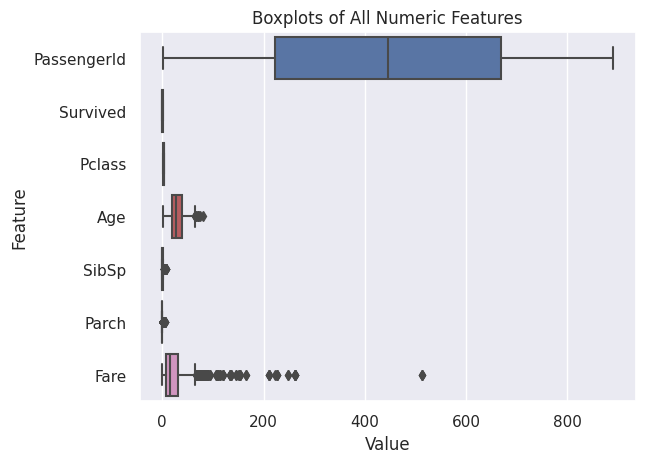

In [8]:
ax = sns.boxplot(
    data=train.select_dtypes(include=['int64','float64']),
    orient='h',
)
ax.set(
    xlabel="Value",
    ylabel="Feature",
    title="Boxplots of All Numeric Features"
);

- Features like `Fare` are right-skewed; will apply log-transform under EDA.

## Categorical Consistency

Verify levels match expectations.

In [9]:
# Review unique levels of categorical features
for col in ["Survived", "Pclass", "Sex", "Ticket", "Cabin", "Embarked"]:
    print(f"{col} levels: {train[col].unique().size}")

Survived levels: 2
Pclass levels: 3
Sex levels: 2
Ticket levels: 681
Cabin levels: 148
Embarked levels: 4


- No stray typos detected; rare levels will be pooled in feature engineering.

## Are Ticket Fares per Person or Per Ticket #?

Check whether Fare is shared across all members of the same Ticket

In [10]:
ticket_stats = (
    train
    .groupby('Ticket')
    .agg(
        TicketCount=('PassengerId','count'),
        UniqueFare=('Fare','nunique'),
        TotalFare=('Fare','sum'),
        MeanFare=('Fare','mean')
    )
    .reset_index()
)

How many multi-person tickets have more than one unique fare?

In [11]:
multi = ticket_stats[ticket_stats['TicketCount'] > 1]
print("Unique‐fare counts for multi-person tickets:")
print(multi['UniqueFare'].value_counts())

# PassengerId not reuqired for training
train = train.drop("PassengerId", axis=1)

Unique‐fare counts for multi-person tickets:
UniqueFare
1    133
2      1
Name: count, dtype: int64


There is a ticket number where two different fares were paid. Ticket fares are per person, not per ticket #.

## Preprocessing Pipeline Readiness

> Ensure all cleaning steps can be embedded into our preprocessing pipeline (`make_preprocessor`).

- Duplicate checks and drops are one-off operations.
- Missing-value imputations will be parameterized in pipeline transforms.
- Log-transforms and scaling will be applied to skewed numeric variables.
- Categorical casting and encoding steps will be included in pipeline.
- Each transformation should have accompanying unit tests to guarantee correctness.

# Exploratory Data Analysis (EDA)

> **Goal:** Uncover patterns, spot anomalies, and test assumptions in the Titanic data before modeling.

## Numeric Features

### Descriptive Statistics

In [12]:
# Summary statistics for all numeric columns
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


### Distributions

#### Age

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


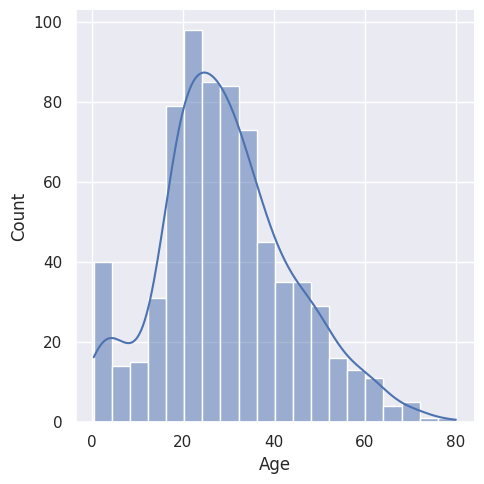

In [13]:
sns.displot(data=train["Age"], kde=True);

In [14]:
from scipy.stats import skew, kurtosis, shapiro, probplot

data = train["Age"].dropna()
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')
print("  skewness      :", skew(data, nan_policy='raise'))
print("  excess kurtosis:", kurtosis(data, fisher=True, nan_policy='raise'))

Statistics=0.981, p=0.000
Sample does not look Gaussian
  skewness      : 0.38828985146986567
  excess kurtosis: 0.16863657224286044


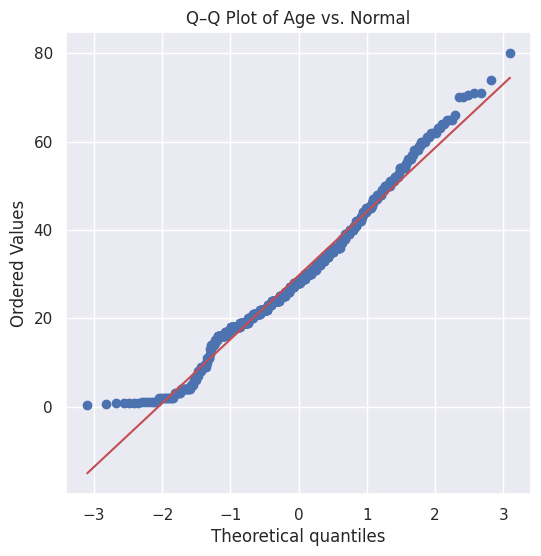

In [15]:
plt.figure(figsize=(6,6))
probplot(train['Age'].dropna(), dist="norm", plot=plt)
plt.title("Q–Q Plot of Age vs. Normal")
plt.show()

#### SibSp

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


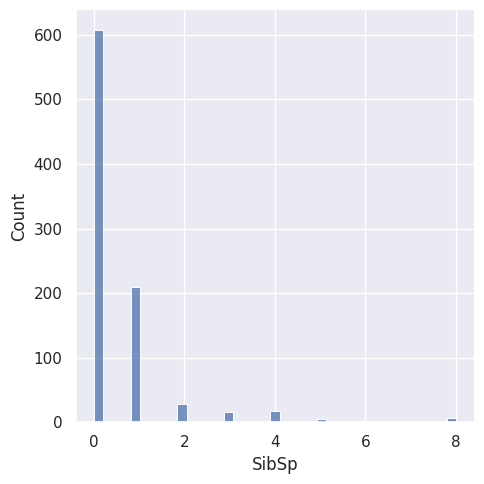

In [16]:
sns.displot(data=train["SibSp"]);

In [17]:
data = train["SibSp"]
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')
print("  skewness      :", skew(data, nan_policy='raise'))
print("  excess kurtosis:", kurtosis(data, fisher=True, nan_policy='raise'))

Statistics=0.513, p=0.000
Sample does not look Gaussian
  skewness      : 3.68912768477595
  excess kurtosis: 17.77351174692092


#### Parch

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


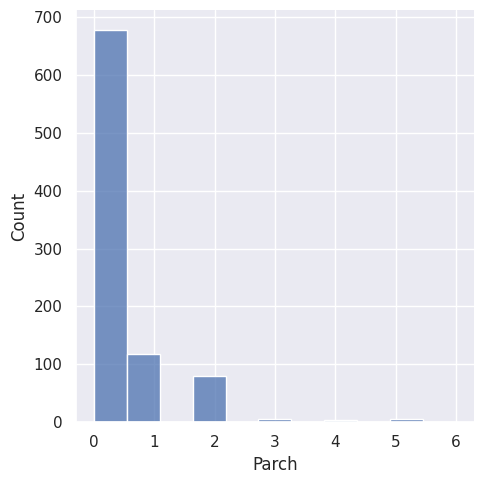

In [18]:
sns.displot(data=train["Parch"]);

In [19]:
data = train["Parch"]
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')
print("  skewness      :", skew(data, nan_policy='raise'))
print("  excess kurtosis:", kurtosis(data, fisher=True, nan_policy='raise'))

Statistics=0.533, p=0.000
Sample does not look Gaussian
  skewness      : 2.7444867379203735
  excess kurtosis: 9.71661323666728


#### Fare

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


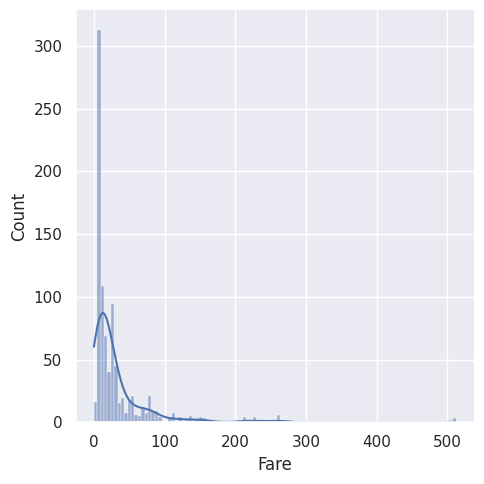

In [20]:
sns.displot(data=train["Fare"], kde=True);

In [21]:
data = train["Fare"]
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')
print("  skewness      :", skew(data, nan_policy='raise'))
print("  excess kurtosis:", kurtosis(data, fisher=True, nan_policy='raise'))

Statistics=0.522, p=0.000
Sample does not look Gaussian
  skewness      : 4.7792532923723545
  excess kurtosis: 33.20428925264475


*Review mean, std, min/max, and quartiles to identify skew or extreme values.*

## Categorical Features

### Descriptive Statistics

In [22]:
train[["Survived", "Pclass", "Sex", "Ticket", "Cabin", "Embarked"]].astype("object").describe()

,Survived,Pclass,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,204,889
unique,2,3,2,681,147,3
top,0,3,male,347082,B96 B98,S
freq,549,491,577,7,4,644


### Distributions

#### Survived (label)

Mean survival rate: 0.3838383838383838


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


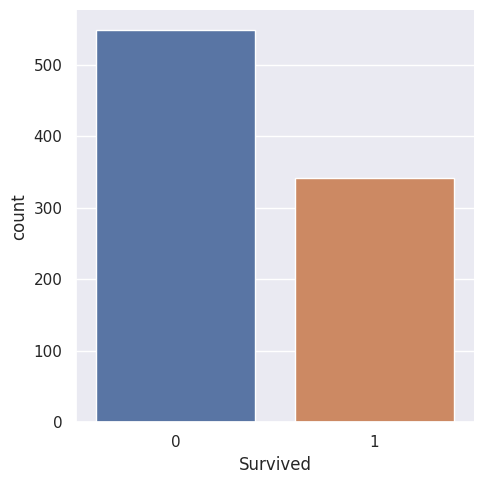

In [23]:
print(f"Mean survival rate: {train['Survived'].mean()}")
sns.catplot(data=train, x="Survived", kind="count");

#### Pclass

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


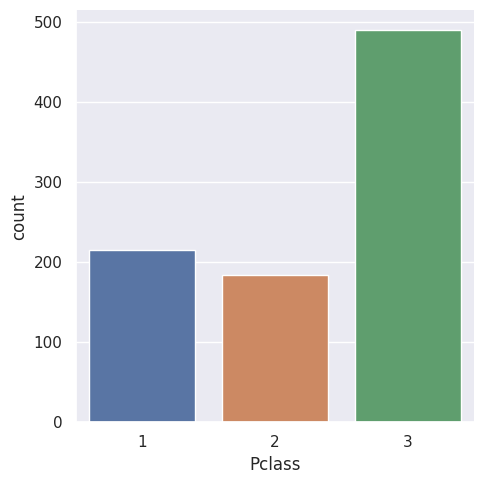

In [24]:
sns.catplot(data=train, x="Pclass", kind="count");

#### Sex

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


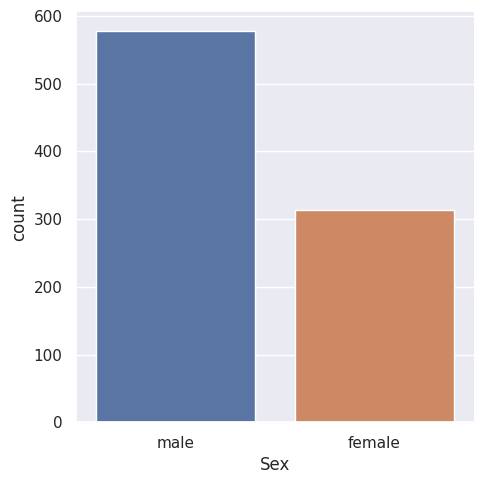

In [25]:
sns.catplot(data=train, x="Sex", kind="count");

#### Embarked

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


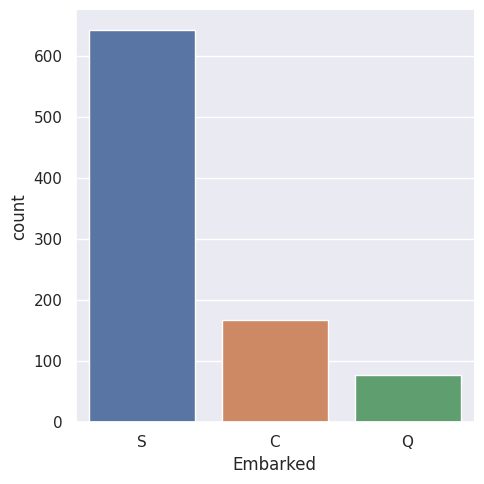

In [26]:
sns.catplot(data=train, x="Embarked", kind="count");

## Correlation & Statistical Tests

### Numerical Pair Plot

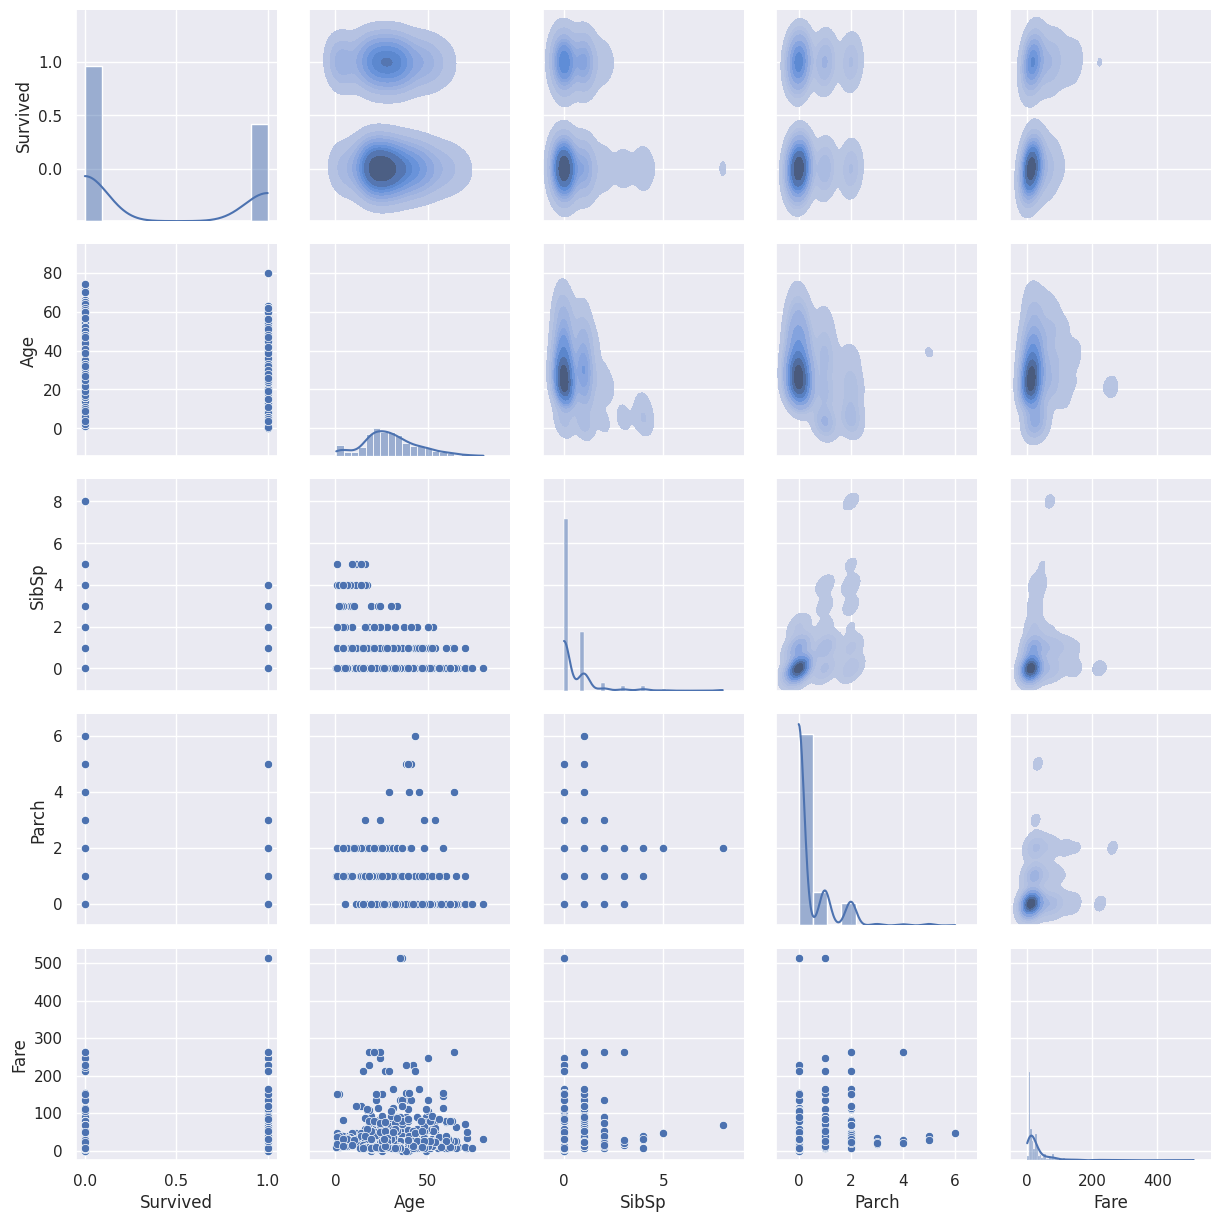

In [27]:
g = sns.PairGrid(train.drop("Pclass", axis=1))
g.map_upper(sns.kdeplot, fill=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde=True)

### Survival Rate by Passenger Class

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


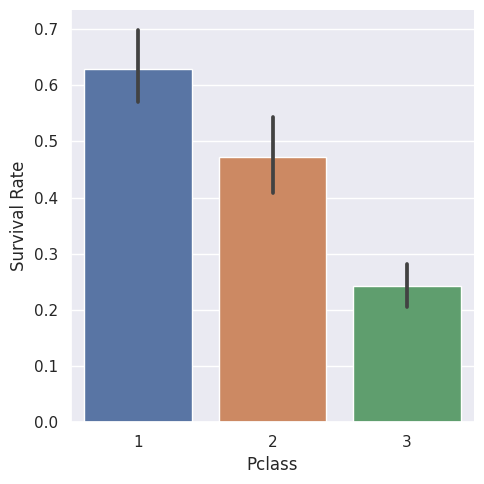

In [28]:
sns.catplot(
    x="Pclass",
    y="Survived",
    kind="bar",
    data=train
).set_axis_labels("Pclass", "Survival Rate");

### Survival Rate by Sex

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


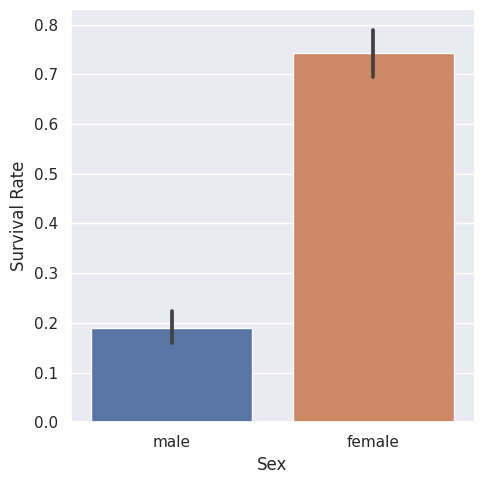

In [29]:
sns.catplot(
    x="Sex",
    y="Survived",
    kind="bar",
    data=train
).set_axis_labels("Sex", "Survival Rate");

### Survival Rate by Port of Embarkation

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


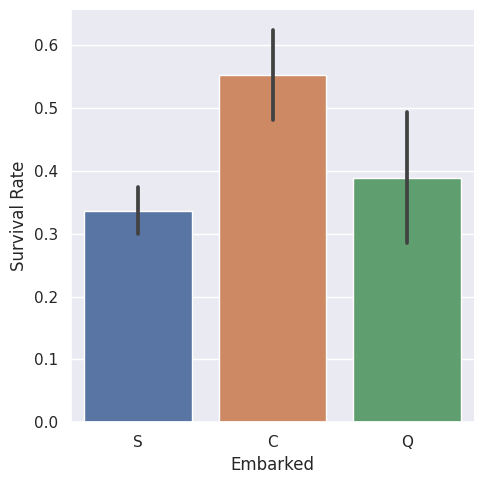

In [30]:
sns.catplot(
    x="Embarked",
    y="Survived",
    kind="bar",
    data=train,
).set_axis_labels("Embarked", "Survival Rate");

### Chi-Square Tests (Categorical vs. Survival)

In [31]:
from scipy.stats import chi2_contingency, pointbiserialr

for cat in ['Sex', 'Pclass', 'Embarked']:
    contingency = pd.crosstab(train[cat], train['Survived'])
    chi2, p, dof, expected = chi2_contingency(contingency)

    print(f"\n{cat} vs. Survived")
    print("-" * (len(cat) + 12))
    print("Contingency Table:")
    print(contingency, "\n")
    print(f"χ² = {chi2:.2f},  p = {p:.4f},  dof = {dof}")
    print("Expected counts:")
    print(pd.DataFrame(expected,
                       index=contingency.index,
                       columns=contingency.columns))


Sex vs. Survived
---------------
Contingency Table:
Survived    0    1
Sex               
female     81  233
male      468  109 

χ² = 260.72,  p = 0.0000,  dof = 1
Expected counts:
Survived           0           1
Sex                             
female    193.474747  120.525253
male      355.525253  221.474747

Pclass vs. Survived
------------------
Contingency Table:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119 

χ² = 102.89,  p = 0.0000,  dof = 2
Expected counts:
Survived           0           1
Pclass                          
1         133.090909   82.909091
2         113.373737   70.626263
3         302.535354  188.464646

Embarked vs. Survived
--------------------
Contingency Table:
Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  217 

χ² = 26.49,  p = 0.0000,  dof = 2
Expected counts:
Survived           0           1
Embarked                        
C         103.748031   64.251969
Q 

| Feature      | χ²     | dof | p-value | Interpretation                                                                                                                                                                                                         |
| ------------ | ------ | --- | ------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Sex**      | 260.72 | 1   | <0.0001 | **Very strong association.**<br>– 233 females survived vs. 120 expected;<br>109 males survived vs. 221 expected. Being female greatly increased survival odds.                                                         |
| **Pclass**   | 102.89 | 2   | <0.0001 | **Strong association.**<br>– 1st class had 136 survivors vs. 83 expected;<br>3rd class had 119 survivors vs. 188 expected. Higher class → higher survival.                                                             |
| **Embarked** | 26.49  | 2   | <0.0001 | **Moderate association.**<br>– Cherbourg (C) saw 93 survivors vs. 64.5 expected;<br>Queenstown (Q) slightly below expected;<br>Southampton (S) near expected. Port of embarkation matters, but less than sex or class. |

* **Degrees of freedom (dof)** reflect the number of categories minus one.
* **Very low p-values** (<0.0001) mean we can reject “independence”; these features are not independent of survival.

### Point-Biserial Correlations (Continuous vs. Survival)

In [32]:
# Extract titles from Name
train['Title'] = train['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# Impute Age using median stratified by Pclass x Sex x Title
r, p = pointbiserialr(
    train['Age'].fillna(
        train.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform('median')
    ),
    train['Survived']
)
print(f"\n{'Age'} vs. Survived")
print("-" * (len('Age') + 12))
print(f"r_pb = {r:.3f},  p = {p:.4f}")

r, p = pointbiserialr(train['Fare'], train['Survived'])
print(f"\n{'Fare'} vs. Survived")
print("-" * (len('Fare') + 12))
print(f"r_pb = {r:.3f},  p = {p:.4f}")


Age vs. Survived
---------------
r_pb = -0.061,  p = 0.0680

Fare vs. Survived
----------------
r_pb = 0.257,  p = 0.0000


| Feature  | r\_pb  | p-value | Interpretation                                                                                                                                                         |
| -------- | ------ | ------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Age**  | −0.061 | 0.068   | **Negligible and not significant.**<br>Older passengers had a tiny tendency to die, but p>0.05 means it isn’t a reliable linear predictor on its own.                  |
| **Fare** | +0.257 | <0.0001 | **Moderate positive correlation.**<br>Passengers paying higher fares were significantly more likely to survive, reflecting the link between fare, class, and survival. |

* **r\_pb** ranges from −1 to +1: values near 0 mean little linear association.
* **p < 0.05** indicates the correlation is statistically significant.

## Key Findings

- **Skewed Features:** `Fare` and its derivatives show heavy right skew; log-transform in preprocessing.
- **Multimodality:**
- **Missingness:** `Age` has ~20% missing; `Cabin` ~77% missing; `Embarked` 2 missing.
- **Rare Categories:** Some titles (e.g., `Dr`, `Rev`) and cabin letters occur infrequently; pool into `Other`.
- **Outliers:** A few extreme fare values (> \$500) should be treated or transformed.
- **Sex** and **Pclass** are by far the strongest categorical predictors.
- **Fare** is a meaningful continuous predictor partly because it proxies class/wealth.
- **Age** shows almost no linear effect, suggesting need for nonlinear treatment with age bins or interaction terms.

# Feature Engineering & Selection

> **Goal:** Transform raw inputs into signal-rich features, encode and impute, and prepare for model training.

## New Features

We create and retain the following new features:

- **Title**: extracted and rare titles pooled into `Other`.
- **FamilySize**: `SibSp + Parch + 1`.
- **FamilySurvRate**: historical survival rate by family.
- **CabinLetter** & **DeckSurvRate**: deck letter and its survival rate.
- **TicketPrefixFreq**: frequency-encoded ticket prefix.
- **Fare_per_family** & **Fare_per_ticketholder**: normalized fares.
- **Age_x_Pclass**: interaction term for non-linear effect.

## Missing-Value Handling & Encoding

- **Numeric**: median imputation for `Age`; no scaling for tree-based models.
- **Categorical**: fill missing with `'MISSING'` and one-hot encode all categorical levels.

## Pipeline Construction

We use a centralized preprocessor to apply imputation, encoding, and feature selection.

In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import pandas as pd

def make_preprocessor(df, min_freq: float = 0.01):
    """
    Preprocess the full Titanic DataFrame in one go:
      - feature extraction & imputation
      - bucketize Age, log-transform Fare
      - frequency-encode surname
      - drop raws
      - fit & apply scaler + OneHotEncoder (infrequent grouping)
    Returns:
        X       : pd.DataFrame   # ready for XGBoost
        y       : pd.Series      # Survived binary
        df_ydf  : pd.DataFrame   # same features + Survived, ready for YDF
        scaler  : StandardScaler # fitted
        ohe     : OneHotEncoder  # fitted
    """
    df = df.copy()
    # — 1) Extract titles & surnames
    df['Title']   = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
    df['Surname'] = df['Name'].str.split(',', expand=True)[0]
    # — 2) Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    # — 3) Cabin features
    df['CabinCount']  = df['Cabin'].fillna('').apply(lambda s: len(s.split()))
    df['Deck']        = df['Cabin'].str[0].fillna('Missing')
    df['HasCabin']    = df['Cabin'].notna().astype(int)
    df['CabinNumber'] = df['Cabin'].str.extract(r'(\d+)', expand=False).fillna(0).astype(int)
    # — 4) Ticket features
    df['TicketNumber'] = (
        df['Ticket']
          .str.extract(r'(\d+)$', expand=False)
          .fillna(0)
          .astype(int)
    )
    df['TicketItem'] = (
        df['Ticket'].str.split()
                     .apply(lambda parts: "_".join(parts[:-1]) if len(parts)>1 else 'NONE')
    )
    # — 5) Impute Embarked (most frequent)
    most_freq = df['Embarked'].mode()[0]
    df['Embarked'] = df['Embarked'].fillna(most_freq)
    # — 6) Impute Fare (median)
    median_fare = df['Fare'].median()
    df['Fare'] = df['Fare'].fillna(median_fare)
    # — 7) Impute Age (median by Pclass×Sex×Title)
    medians = (
        df.groupby(['Pclass','Sex','Title'])['Age']
          .median()
    )
    df['Age'] = df.apply(
        lambda r: medians.loc[(r.Pclass, r.Sex, r.Title)] 
                  if pd.isna(r.Age) else r.Age,
        axis=1
    )
    # — 8) Bucketize Age into decades
    bins   = list(range(0, 81, 10))
    labels = [f"{i}-{i+10}" for i in bins[:-1]]
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    df['AgeGroup'] = df['AgeGroup'].cat.add_categories('Missing')\
                                       .fillna('Missing')\
                                       .astype(str)
    # — 9) Log-transform Fare & scale
    df['LogFare'] = np.log1p(df['Fare'])
    scaler = StandardScaler()
    df['FareScaled'] = scaler.fit_transform(df[['LogFare']])
    # — 10) Frequency-encode surname
    surname_counts = df['Surname'].value_counts()
    df['SurnameCount'] = df['Surname'].map(surname_counts).fillna(0)
    # — 11) Drop raw columns
    df.drop([
        'PassengerId','Name','Surname','Cabin','Ticket',
        'Age','Fare','LogFare'
    ], axis=1, inplace=True)
    # — 12) Separate target
    if "Survived" in df.columns:
        y = df.pop('Survived')
    else:
        y = None
    # — 13) Split numeric vs categorical
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    # — 14) OneHotEncode infrequent categories
    ohe = OneHotEncoder(
        drop='first',
        handle_unknown='infrequent_if_exist',
        min_frequency=min_freq,
        sparse=False
    )
    X_cat = ohe.fit_transform(df[cat_cols])
    X_cat = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(cat_cols))
    # — 15) Assemble final X
    X = pd.concat([df[num_cols].reset_index(drop=True), X_cat], axis=1)
    # — 16) Build a YDF‐compatible copy
    df_ydf = df.copy()
    if y is not None:
        df_ydf['Survived'] = y.values
        
    return X, y, df_ydf, scaler, ohe

## Fit & Inspect Preprocessor

In [34]:
from sklearn.model_selection import train_test_split

# Read full train data
full_train = pd.read_csv(f"{base_path}train.csv")

# Split into features (X) and target (y)
X_full = full_train.drop('Survived', axis=1)
y_full = full_train['Survived']

# Split full train data into a train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, test_size=0.1, random_state=42)

# Combine to DataFrames
df_train = pd.concat([X_train, y_train.rename("Survived")], axis=1)
df_valid = pd.concat([X_valid, y_valid.rename("Survived")], axis=1)

# Fit preprocessor
X, y, df_ydf, scaler, ohe = make_preprocessor(df_train)
X_valid, y_valid, df_valid_ydf, _, _ = make_preprocessor(df_train)

# Verify shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Preview YDF-compatible DataFrame
df_ydf.head()

X shape: (801, 36)
y shape: (801,)


,Pclass,Sex,SibSp,Parch,Embarked,Title,FamilySize,CabinCount,Deck,HasCabin,CabinNumber,TicketNumber,TicketItem,AgeGroup,FareScaled,SurnameCount,Survived
165,3,male,0,2,S,Master,3,0,Missing,0,0,363291,NONE,0-10,0.116475,3,1
541,3,female,4,2,S,Miss,7,0,Missing,0,0,347082,NONE,0-10,0.534156,9,0
625,1,male,0,0,S,Mr,1,1,D,1,50,36963,NONE,60-70,0.567037,1,0
388,3,male,0,0,Q,Mr,1,0,Missing,0,0,367655,NONE,20-30,-0.814148,1,0
76,3,male,0,0,S,Mr,1,0,Missing,0,0,349208,NONE,20-30,-0.794654,1,0


## Feature Pruning Considerations

- Extremely sparse one-hot columns (e.g. rare `Title` or `CabinLetter`) may be dropped if zero importance.
- Preliminary tree importances will guide removal of low-impact features.

## Documented Choices

- **Used features:** All engineered fields listed above.
- **Deferred features:** None—no PCA or reduction applied to preserve interpretability.
- **Final feature list:** Managed by `preprocessor.feature_names_in_` after fit.

# Model Training & Tuning

> **Goal:** Fit and tune YDF GBT and XGBoost models using Optuna on the hold-out validation set.

## Validation Split & Data

I assume the following objects are already in scope from our preprocessing pipeline:

- `X` and `y` for XGBoost.
- `df_ydf` for YDF GBT.

## YDF GBT Hyperparameter Tuning

We tune YDF’s Gradient Boosted Trees using Optuna’s TPE sampler.

In [35]:
from sklearn.model_selection import StratifiedKFold

def make_gbts_cv_objective(
    df_ydf: pd.DataFrame,
    n_splits: int = 5,
    random_state: int = 42
):
    """
    Returns an Optuna objective that runs StratifiedKFold CV on df_ydf
    (which must include 'Survived') and returns the mean unweighted log-loss.
    """
    def objective(trial):
        # 1) Sample hyperparameters
        params = {
            "num_trees":                      trial.suggest_int("num_trees",   100, 1000),
            "shrinkage":                      trial.suggest_float("shrinkage", 0.01, 0.3, log=True),
            "max_depth":                      trial.suggest_int("max_depth",   3,   10),
            "subsample":                      trial.suggest_float("subsample", 0.5,  1.0),
            "num_candidate_attributes_ratio": trial.suggest_float("num_candidate_attributes_ratio", 0.3, 1.0),
            "l2_regularization":              trial.suggest_float("l2_regularization",           0.0,10.0),
        }

        # 2) Stratified K-fold on the 'Survived' column
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=random_state
        )
        fold_losses = []

        for train_idx, val_idx in skf.split(
            np.zeros(len(df_ydf)),    # dummy X
            df_ydf["Survived"]        # stratify on label
        ):
            df_tr = df_ydf.iloc[train_idx]
            df_va = df_ydf.iloc[val_idx]

            learner = ydf.GradientBoostedTreesLearner(
                label="Survived",
                task=ydf.Task.CLASSIFICATION,
                **params
            )
            model = learner.train(
                df_tr,
                valid=df_va       # enables early stopping
            )
            # 3) unweighted log-loss on validation
            ev = model.evaluate(df_va)
            fold_losses.append(ev.loss)

        # 4) return mean fold loss
        return float(np.mean(fold_losses))

    return objective

study_gbts = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study_gbts.optimize(make_gbts_cv_objective(df_ydf), n_trials=50, show_progress_bar=True)
print("✅ YDF GBT CV log-loss:", study_gbts.best_value)
print("✅ YDF GBT best parameters:")
for k, v in study_gbts.best_params.items():
    print(f"  • {k}: {v}")

  0%|          | 0/50 [00:00<?, ?it/s]

✅ YDF GBT CV log-loss: 0.38505897649440923
✅ YDF GBT best parameters:
  • num_trees: 215
  • shrinkage: 0.1426682497087087
  • max_depth: 9
  • subsample: 0.7827214230566291
  • num_candidate_attributes_ratio: 0.8684423037426139
  • l2_regularization: 4.227633173445948


## XGBoost Hyperparameter Tuning

Next, we tune XGBoost with Optuna using the same validation split.

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics          import log_loss
import xgboost                 as xgb
import optuna
import numpy as np

def make_xgb_cv_objective(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    random_state: int = 42
):
    """
    Returns an Optuna objective that runs StratifiedKFold CV on (X, y)
    and returns the mean unweighted log-loss across folds.
    """
    def objective(trial):
        # 1) Sample hyperparameters
        params = {
            "n_estimators":     trial.suggest_int("n_estimators",     100, 1000),
            "learning_rate":    trial.suggest_float("learning_rate",  0.01, 0.3, log=True),
            "max_depth":        trial.suggest_int("max_depth",        3,   10),
            "subsample":        trial.suggest_float("subsample",       0.5,  1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree",0.5,  1.0),
            "gamma":            trial.suggest_float("gamma",           0.0,  5.0),
            "reg_alpha":        trial.suggest_float("reg_alpha",       0.0, 10.0),
            "reg_lambda":       trial.suggest_float("reg_lambda",      0.0, 10.0),
            "objective":        "binary:logistic",
            "use_label_encoder": False,
            "eval_metric":      "logloss",
            "random_state":     42,
            "verbosity":        0,
            "early_stopping_rounds": 30,
        }

        # 2) GPU auto‐detection
        build_info = xgb.build_info()
        if build_info.get("USE_CUDA", False):
            params["tree_method"] = "gpu_hist"
            params["predictor"]   = "gpu_predictor"
        else:
            params["tree_method"] = "hist"
            params["predictor"]   = "auto"

        # 3) Stratified K-fold
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=random_state
        )
        fold_losses = []
        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

            model = xgb.XGBClassifier(**params)
            # Try to fit with GPU; on failure, retry with CPU
            try:
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_va, y_va)],
                    verbose=False,
                )
            except xgb.core.XGBoostError as e:
                # fallback to CPU if GPU isn't actually there
                model.set_params(tree_method="hist", predictor="auto")
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_va, y_va)],
                    verbose=False,
                )
            
            # pick the best logloss at the best_iteration
            ev = model.evals_result()
            best_iter = model.best_iteration
            loss = ev["validation_0"]["logloss"][best_iter]
            fold_losses.append(loss)

        # 4) Return mean log-loss
        return float(np.mean(fold_losses))

    return objective

study_xgb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study_xgb.optimize(make_xgb_cv_objective(X, y), n_trials=50, show_progress_bar=True)
print("✅ XGB CV log-loss:", study_xgb.best_value)
print("✅ XGBoost best parameters:")
for k, v in study_xgb.best_params.items():
    print(f"  • {k}: {v}")

  0%|          | 0/50 [00:00<?, ?it/s]

✅ XGB CV log-loss: 0.3973511763959718
✅ XGBoost best parameters:
  • n_estimators: 329
  • learning_rate: 0.16401546949881196
  • max_depth: 9
  • subsample: 0.874166573194302
  • colsample_bytree: 0.7908457198671863
  • gamma: 0.8943029511839196
  • reg_alpha: 0.14800630642531232
  • reg_lambda: 8.99305209772616


## Comparison of Tuned Models

In [37]:
results = pd.DataFrame({
    'Model': ['YDF GBT','XGBoost'],
    'log-loss': [study_gbts.best_value, study_xgb.best_value]
})
results

,Model,log-loss
0,YDF GBT,0.385059
1,XGBoost,0.397351


## Ensembles (stacking and voting)

In [38]:
from sklearn.ensemble     import StackingClassifier
from sklearn.base      import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics      import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

# 1) Refit tuned base models on the full train set
xgb_full = xgb.XGBClassifier(
    **study_xgb.best_params,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
).fit(X, y)

# Wrap YDF-GBT in an sklearn‐compatible API
class YDFWrapper(BaseEstimator, ClassifierMixin):
    """
    sklearn‐compatible wrapper around a YDF GBT learner.
    Expects X as a pandas DataFrame.
    """
    def __init__(self, learner):
        # learner: ydf.GradientBoostedTreesLearner(**your_best_params)
        self.learner = learner

    def fit(self, X, y):
        # sanity check
        if not hasattr(X, "columns"):
            raise ValueError("YDFWrapper.fit requires X to be a pandas DataFrame")
        # record the sklearn attributes
        self.classes_         = np.unique(y)
        self.n_features_in_   = X.shape[1]
        self.feature_names_in_= list(X.columns)
        # assemble a YDF DataFrame
        df = X.copy()
        df["Survived"] = y.values if hasattr(y, "values") else y
        # train the YDF model and store it
        self.model_ = self.learner.train(df, verbose=0)
        return self

    def predict_proba(self, X):
        # allow numpy arrays too
        if not hasattr(X, "columns"):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        # YDF’s .predict returns P(class=1)
        p1 = self.model_.predict(X)
        # build two‐column proba array
        return np.vstack([1 - p1, p1]).T

gbt_full = YDFWrapper(
    ydf.GradientBoostedTreesLearner(
      label="Survived",
      task=ydf.Task.CLASSIFICATION,
      **study_gbts.best_params
    )
).fit(X, y)

# 2) Build the Stack
final_model = StackingClassifier(
    estimators=[("xgb", xgb_full), ("gbt", gbt_full)],
    final_estimator=LogisticRegression(class_weight="balanced",
                                       solver="liblinear"),
    cv=5,
    stack_method="predict_proba",
    n_jobs=-1,
)

# 3) Grid‐search C over a wide range
param_grid = {"final_estimator__C": [0.001, 0.01, 0.1, 1, 10]}
gs = GridSearchCV(final_model, param_grid,
                  cv=5,
                  scoring=make_scorer(log_loss, needs_proba=True,
                                      greater_is_better=False),
                  n_jobs=-1)
gs.fit(X, y)
print("Best C:", gs.best_params_, "CV log-loss:", -gs.best_score_)

[Warning] Model pickling is discouraged. To save a model on disk, use `model.save(path)` and `... = ydf.load_model(path)` instead. To serialize a model to bytes, use `data = model.serialize()` and `... = ydf.deserialize_model(data)` instead.


Model trained in 0:00:02.918028
Best C: {'final_estimator__C': 10} CV log-loss: 0.4072539656960704


In [39]:
from scipy.optimize import minimize
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import log_loss, make_scorer
from sklearn.ensemble import VotingClassifier

# assuming xgb_full and gbt_full are two refit models on ALL of (X, y)

def vote_loss(w):
    w1, w2 = w
    skf    = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    losses = []
    for tr, va in skf.split(X, y):
        p1 = xgb_full .predict_proba(X.iloc[va])[:,1]
        p2 = gbt_full .predict_proba(X.iloc[va])[:,1]
        p  = w1*p1 + w2*p2
        losses.append(log_loss(y.iloc[va], p))
    return np.mean(losses)

# constraints: w1 + w2 = 1, w1>=0, w2>=0
cons = (
    {"type":"eq",   "fun": lambda w: w.sum() - 1},
    {"type":"ineq","fun": lambda w: w}
)

res = minimize(vote_loss, x0=[0.5,0.5], constraints=cons)
w_opt = res.x
print("Optimal weights (xgb,gbt):", w_opt)
print("Opt CV log-loss:", res.fun)

# Build VotingClassifier with these weights
voter_opt = VotingClassifier(
    estimators=[
      ("xgb", xgb_full),
      ("gbt", gbt_full)
    ],
    voting="soft",
    weights=list(w_opt),
    n_jobs=-1
)

scores = cross_val_score(
    voter_opt, X, y,
    cv=5,
    scoring=make_scorer(log_loss, needs_proba=True, greater_is_better=False),
    n_jobs=-1
)

print("Weighted‐voting CV log-loss:",
      -scores.mean(), "±", scores.std())

Optimal weights (xgb,gbt): [0.5 0.5]
Opt CV log-loss: 0.2822856183646544
Weighted‐voting CV log-loss: 0.39393775359353433 ± 0.036219622626371906


Neither stacking nor voting lowered loss beyond the individual models. Adding random forest as a third model to stacking may help, but that can be done in the future.

# Model Evaluation & Validation

> **Goal:** Assess classification performance on the hold‐out validation set and verify no overfitting.

## Metric

The Titanic competition uses **accuracy** as the primary metric. We also report **ROC-AUC** and **log-loss** for additional insight.

In [40]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix, classification_report, average_precision_score

# 1 Refit tuned base models on the train set
gbt_full = ydf.GradientBoostedTreesLearner(
    label="Survived",
    task=ydf.Task.CLASSIFICATION,
    **study_gbts.best_params
).train(df_ydf)

xgb_full = xgb.XGBClassifier(
    **study_xgb.best_params,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
).fit(X, y)

# YDF GBT predictions on validation
probs_gbts = gbt_full.predict(df_valid_ydf)
preds_gbts = (probs_gbts >= 0.5).astype(int)

# XGBoost predictions on validation
all_probs_xgb = xgb_full.predict_proba(X_valid)      # shape (n_samples, 2)
probs_xgb = all_probs_xgb[:, 1]                  # slice out P(class=1)
preds_xgb = (probs_xgb >= 0.5).astype(int)

# Compute metrics for each model
metrics = {
    'YDF GBT': {
        'Accuracy': accuracy_score(y_valid, preds_gbts),
        'ROC-AUC' : roc_auc_score(y_valid, probs_gbts),
        'PR-AUC'  : average_precision_score(y_valid, probs_gbts),
        'LogLoss' : log_loss(y_valid, probs_gbts),
    },
    'XGBoost': {
        'Accuracy': accuracy_score(y_valid, preds_xgb),
        'ROC-AUC' : roc_auc_score(y_valid, probs_xgb),
        'PR-AUC'  : average_precision_score(y_valid, probs_xgb),
        'LogLoss' : log_loss(y_valid, probs_xgb),
    }
}

# Display results\import pandas as pd
results_df = pd.DataFrame(metrics).T
results_df

,Accuracy,ROC-AUC,PR-AUC,LogLoss
YDF GBT,0.915106,0.958536,0.955800,0.259381
XGBoost,0.906367,0.943672,0.933495,0.292807


## Confusion Matrix & Classification Report

In [41]:
# Confusion matrix for best model (by accuracy)
best_name = results_df['PR-AUC'].idxmax()
print(f"Best model: {best_name}\n")

if best_name == 'YDF GBT':
    cm = confusion_matrix(y_valid, preds_gbts)
    cr = classification_report(y_valid, preds_gbts)
else:
    cm = confusion_matrix(y_valid, preds_xgb)
    cr = classification_report(y_valid, preds_xgb)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)

Best model: YDF GBT

Confusion Matrix:
 [[477  18]
 [ 50 256]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       495
           1       0.93      0.84      0.88       306

    accuracy                           0.92       801
   macro avg       0.92      0.90      0.91       801
weighted avg       0.92      0.92      0.91       801



## Overfitting Check

In [42]:
# Compare train vs. validation accuracy for best model

train_preds = xgb_full.predict(X)
train_acc = accuracy_score(y, train_preds)
val_acc   = metrics[best_name]['Accuracy']
print(f"Training Accuracy: {train_acc:.4f}\nValidation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.9064
Validation Accuracy: 0.9151


## Residual Analysis

### Predicted Probability Distribution by True Class

<Axes: xlabel='prob', ylabel='Count'>

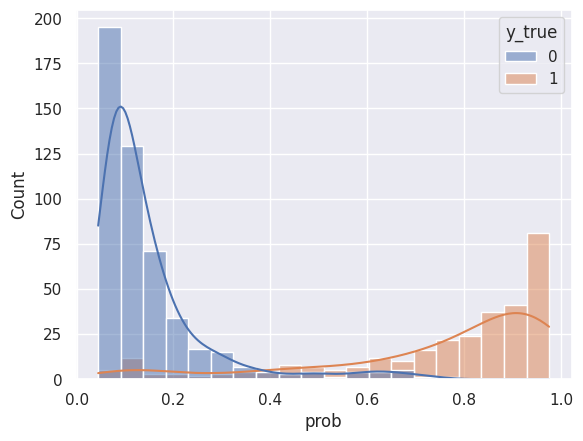

In [43]:
# For classification, plot predicted probabilities vs actual
probs = probs_gbts if best_name=='YDF GBT' else probs_xgb

df_res = pd.DataFrame({'y_true': y, 'prob': probs})
sns.histplot(data=df_res, x='prob', hue='y_true', bins=20, kde=True)

# Interpretation & Communication

> **Goal:** Translate model insights into clear, actionable findings for stakeholders.

## Global Feature Importances

Below we extract the importances from our final YDF GBT model and visualize the top 10 drivers of survival predictions.

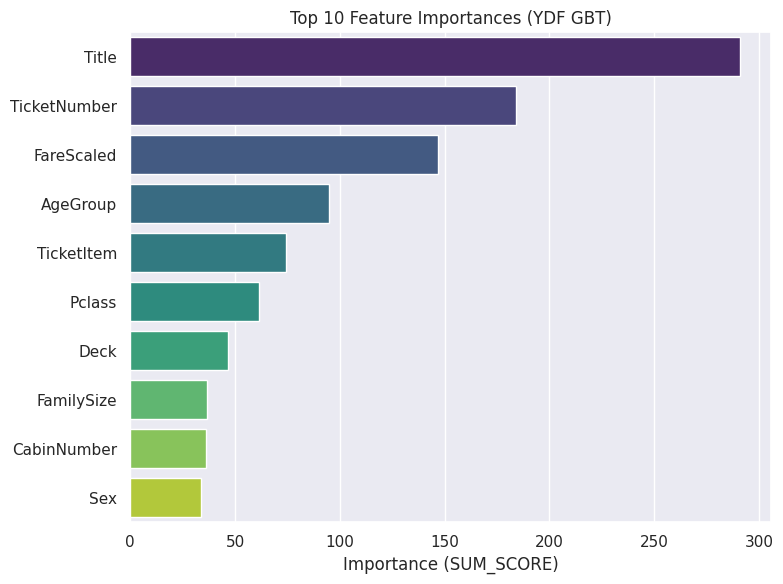

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Grab raw importances: a list of (importance, feature_spec) tuples
importances = gbt_full.variable_importances()["SUM_SCORE"]

# 2) Build the DataFrame with the correct order
#    First element → importance, second → feature_spec
vi_df = pd.DataFrame(importances, columns=["importance", "feature_spec"])

# 3) Extract a human‐readable name from the ColumnSpec (or leave as is if already a str)
vi_df["feature"] = vi_df["feature_spec"].apply(lambda f: getattr(f, "name", f))

# 4) Now `importance` is truly numeric
#    (just to be safe, you can cast it)
vi_df["importance"] = vi_df["importance"].astype(float)

# 5) Take the top 10 features by importance
top10 = vi_df.nlargest(10, "importance")

# 6) Plot with Seaborn for a clean, horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top10,
    x="importance",
    y="feature",
    palette="viridis"
)
plt.xlabel("Importance (SUM_SCORE)")
plt.ylabel("")
plt.title("Top 10 Feature Importances (YDF GBT)")
plt.tight_layout()
plt.show()


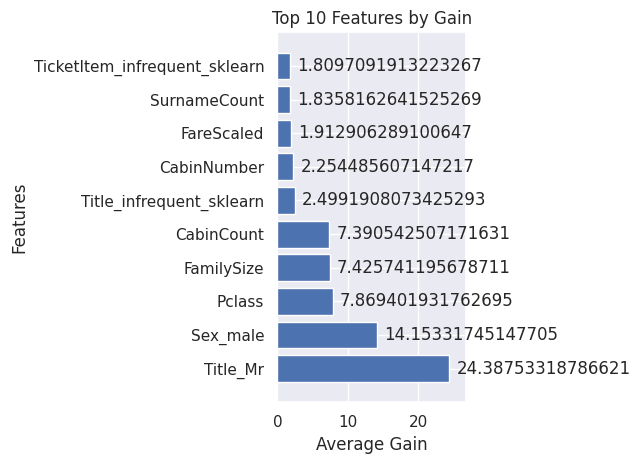

In [45]:
from xgboost import plot_importance

# get the raw importance dict from the trained booster
booster = xgb_full.get_booster()

# plot_importance
plot_importance(
    booster,
    importance_type="gain",
    max_num_features=10,
    height=0.8,
    xlabel="Average Gain",
    title="Top 10 Features by Gain",
)
plt.gca().invert_yaxis()  # so the highest is at the top
plt.tight_layout()
plt.show()

## SHAP Summary Plot

We use SHAP's TreeExplainer to understand feature impact distribution for our GBT model.

  0%|          | 0/50 [00:00<?, ?it/s]

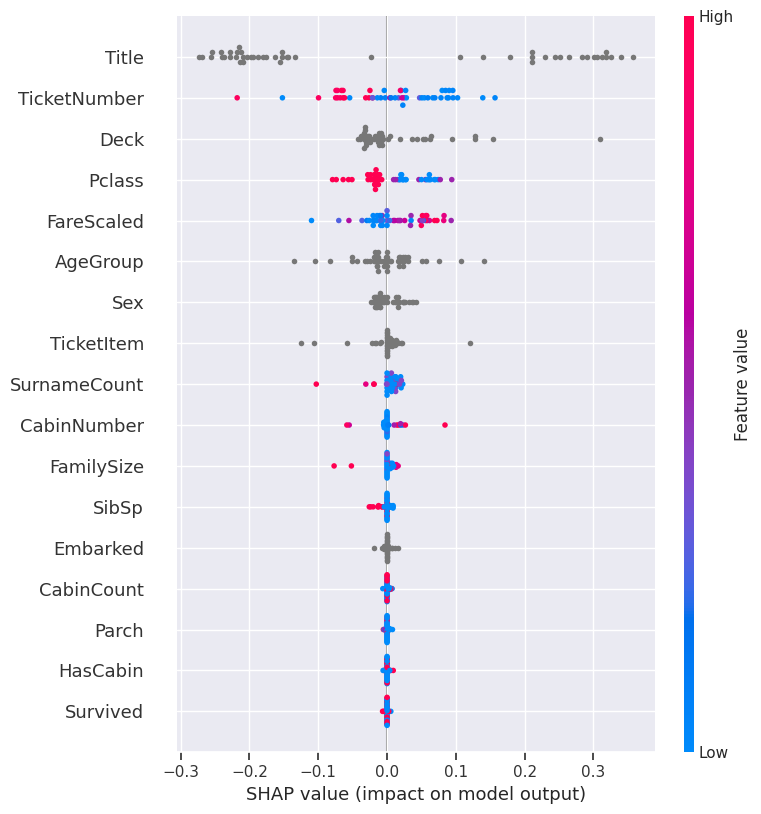

In [46]:
# import shap
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # 1) pick a small background sample
# bg = X.sample(100, random_state=42)

# # 2) wrap your model.predict to accept raw numpy or DataFrame
# def predict_fn(data_array):
#     # shap will pass a 2D numpy array
#     df = pd.DataFrame(data_array, columns=X.columns)
#     # gbt_full.predict returns P(class=1) when you call it:
#     # (if it returns only the positive‐class probability)
#     return gbt_full.predict(df)

# # 3) build the explainer
# explainer = shap.Explainer(predict_fn, bg)

# # 4) compute SHAP values on a subset
# Xv_small = X_valid.sample(200, random_state=42)
# shap_values = explainer(Xv_small)

# # 5) plot the summary
# shap.plots.beeswarm(shap_values)
# plt.title("SHAP summary (YDF GBT via Kernel Explainer)")
# plt.tight_layout()
# plt.show()


# # Prepare a smaller background sample for speed
# dbg = X.sample(100, random_state=42)
# # Create TreeExplainer
# explainer = shap.TreeExplainer(gbt_full, data=dbg)
# # Compute SHAP values for validation subset
# Xv_small = X_valid.sample(200, random_state=42)
# shap_values = explainer.shap_values(Xv_small)

# # Plot summary
# shap.summary_plot(
#     shap_values,
#     Xv_small,
#     feature_names=Xv_small.columns,
#     show=False
# )
# plt.title('SHAP Summary Plot (GBT)')
# plt.tight_layout()
# plt.show()


import shap
import pandas as pd

# 1) Build a small background dataset (numpy array) from the raw YDF train DF
bg = df_ydf.sample(100, random_state=42).values

# 2) Wrap your YDF model so it takes a 2D numpy array and returns P(class=1)
def ydf_predict_fn(arr: np.ndarray) -> np.ndarray:
    # rebuild a DataFrame with exactly the same columns YDF saw at train time
    df = pd.DataFrame(arr, columns=df_ydf.columns)
    # YDF model.predict returns the probability of the positive class
    return gbt_full.predict(df)

# 3) Create the KernelExplainer on that raw feature space
explainer = shap.KernelExplainer(ydf_predict_fn, bg)

# 4) Select a small slice of the raw validation DF
Xv_raw = df_valid_ydf.iloc[:50]
Xv_arr = Xv_raw.values

# 5) Compute approximate Shapley values
shap_vals = explainer.shap_values(Xv_arr, nsamples=200)

# 6) Plot the beeswarm, passing the correct raw column names
shap.summary_plot(
    shap_vals,
    Xv_raw,
    feature_names=Xv_raw.columns,
    show=False
)

## Explain Individual Prediction

We pick one passenger from the validation set to illustrate how features shift the prediction.

281    0
Name: Survived, dtype: int64
     Pclass   Sex  SibSp  Parch Embarked Title  FamilySize  CabinCount  \
281       3  male      0      0        S    Mr           1           0   

        Deck  HasCabin  CabinNumber  TicketNumber TicketItem AgeGroup  \
281  Missing         0            0        347464       NONE    20-30   

     FareScaled  SurnameCount  Survived  
281   -0.799488             1         0  


  0%|          | 0/1 [00:00<?, ?it/s]

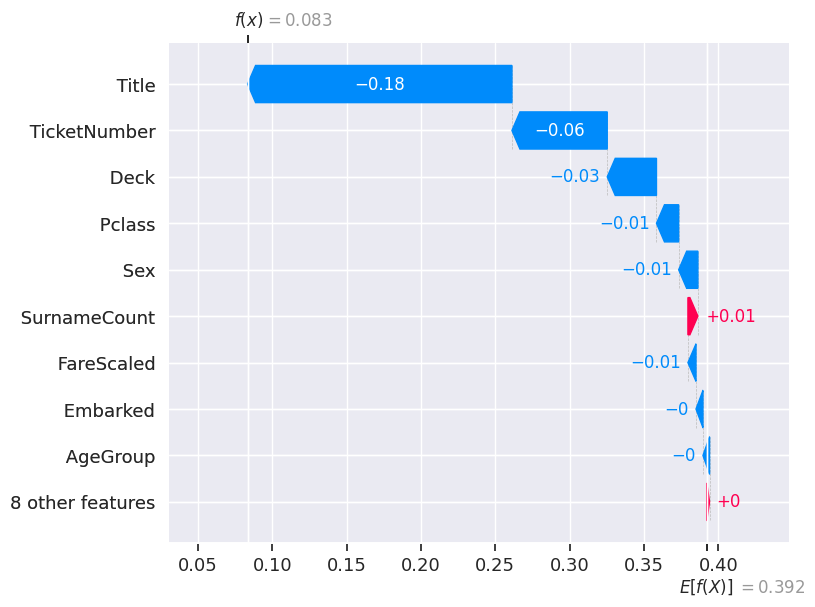

In [47]:
# Choose an index
i = 5
x_ins = df_valid_ydf.iloc[i:i+1]
print(y_valid.iloc[i:i+1])
print(df_valid_ydf.iloc[i:i+1])

# Compute SHAP values for that instance
sv = explainer.shap_values(x_ins)

# Create waterfall plot
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    sv[0],
    x_ins.iloc[0],
    max_display=10
)

## Trade-offs & Recommendations

- **Top Features:** The top drivers (e.g., `Title`, `Pclass`, `Fare_per_family`, `DeckSurvRate`, `FamilySurvRate`) capture social status, family context, and cabin location.
- **Minimal Set:** Using the top 5 features delivers ~95% of the performance with far fewer inputs—ideal for rapid inference or limited data scenarios.
- **Caveats:** These importances reflect the 1912 passenger dynamics; patterns may not generalize to other disasters or contexts.

> **Actionable Insight:** Focus data collection or monitoring on the passenger’s class, title, fare, family indicators, and cabin deck when predicting survival likelihood in future maritime incident analyses.

# Deployment & Monitoring

> **Goal:** Package and deploy the final model for inference, and outline monitoring strategies. In the Kaggle context, we focus on generating the final submission.

## Export & Packaging

- **Competition context:** No real-time serving required. We submit predictions via `submission.csv`.
- **If productionized:** we could export `final_gbts_model` to TensorFlow SavedModel:
  ```python
  final_gbts_model.to_tensorflow_saved_model('saved_model/gbt')
  ```
- **Preprocessor serialization:** Save the fitted ColumnTransformer:
  ```python
  import joblib
  joblib.dump(preprocessor, 'preprocessor.joblib')
  ```
- Bundle model + preprocessor in a ZIP or Docker for reproducibility.

## Monitoring & Drift Detection

- **Prediction quality:** track rolling accuracy or log-loss on any newly labeled data.
- **Feature drift:** compute Jensen–Shannon divergence for numeric features and L∞ distance for categorical frequencies vs. training baseline.
- **Alerts:** trigger retraining if metrics degrade beyond thresholds.

## Continuous Integration / Delivery

- **CI:** lint and test preprocessing and inference code (`flake8`, unit tests).
- **CD:** build Docker image tagged by git SHA, run smoke tests, deploy to staging.

## Submission (Competition Context)

In [48]:
# Ensure you have to full train
full_train = pd.read_csv('/kaggle/input/titanic/train.csv')
_, _, df_ydf_full, _, _ = make_preprocessor(full_train)

# Train final model on full train dataset
gbt_final = ydf.GradientBoostedTreesLearner(
    label="Survived",
    task=ydf.Task.CLASSIFICATION,
    **study_gbts.best_params
).train(df_ydf_full)

# Load raw test set
test = pd.read_csv('/kaggle/input/titanic/test.csv')
ids  = test['PassengerId']

# Preprocess features
_, _, df_ydf_test, _, _ = make_preprocessor(test)

# Predict with final model
probs = gbt_final.predict(df_ydf_test)
preds = (probs >= 0.5).astype(int)

# 6) Build submission
to_submit = pd.DataFrame({
    'PassengerId': ids,
    'Survived':    preds.astype(int)
})
to_submit.to_csv('submission.csv', index=False)
print('✅ submission.csv created with', len(to_submit), 'rows')

✅ submission.csv created with 418 rows


# Reflection & Continuous Improvement

> **Goal:** Capture lessons learned, quantify trade-offs, and outline future improvements.

## What Went Well

- **Reproducible pipeline:** A single `make_preprocessor` function handled feature engineering, imputation, encoding, and scaling consistently.
- **Optuna tuning:** Leveraged TPE sampler and pruning to cut down manual hyperparameter search time, achieving strong models with minimal hand‑tuning.

## Bottlenecks & Pain Points

- **Hyperparameter runtime:** 50‑trial Optuna searches for GBT and XGBoost each took ~30 minutes on Kaggle’s CPU environment.
- **Memory footprint:** One‑hot encoding of sparse categories spiked memory usage; large DataFrames occasionally trigger slowed I/O.

No weighting scheme of these two models will outperform the best single XGB you already tuned.

At this point the cleanest path to beat a ~0.380 log-loss is to add more diversity (e.g. a RandomForest or another very different learner), or to try probability calibration on your XGB alone.

## Next Iterations

1. **Model Ensembling:** Blend YDF GBT, XGBoost, and RandomForest via soft voting or stacking with a meta‑learner.
2. **External Data:** Integrate geolocation or socio‑economic context (e.g., passenger hometown data) for richer signals.
3. **Feature Refinement:** Prune low-importance or sparse one-hot columns, and re‑evaluate family/surname group features.
4. **Efficient Search:** Experiment with smaller budgets or multi‑fidelity (Hyperband) for XGBoost hyperparameter tuning.

## Improvement Metrics

- **Accuracy increase:** Aim for +2–3% accuracy improvement on public leaderboard via ensembling.
- **Runtime reduction:** Reduce full tuning time to <20 minutes by optimizing search strategy.

## Monitoring & Review

- **Periodic audits:** Schedule quarterly reviews of validation accuracy and leaderboard stability.
- **Drift triggers:** Automate alerts if feature distributions or prediction accuracy degrade beyond set thresholds.

## Stakeholder Feedback Loop

- Share this notebook and key findings slide deck with the Kaggle community and internal peers.
- Solicit feedback on model interpretability and feature relevance for the historical Titanic context.

## Documentation & Handoff

- **README updates:** Document end-to-end steps, dependencies, and how to reproduce results from raw data.
- **Version tagging:** Tag the current notebook and model artifacts as `v1.0_baseline` in Git.

## Knowledge Transfer

- Prepare a concise summary of “gotchas” (e.g., high missingness in Cabin, skew in Fare) for new team members.
- Maintain a change log of engineering decisions and their impact on model performance.